In [1]:
import pandas as pd
import numpy as np
import math 
import statistics
import scipy.stats as sts
from prettytable import PrettyTable
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict


import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [134]:
import itertools
from matplotlib.cbook import _reshape_2D
import matplotlib.pyplot as plt
import numpy as np

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

## General information

## [About dataset:](https://www.kaggle.com/dipam7/student-grade-prediction)

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

In [2]:
df = pd.read_csv('student-mat.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [3]:
dfStat = df.describe(include='all').T

for _ in df.columns.tolist():
    dfStat.loc[_,'mode'] = df[_].mode()[0]
    dfStat.loc[_,'unique_val'] = df[_].unique().shape[0]
    dfStat.loc[_,'mode_freq'] = df[_].value_counts().values[0]

dfStat =dfStat.rename(columns={"50%": "median"})
dfStat = dfStat.drop(columns=['count','unique', 'top', 'freq'])
dfStat.iloc[:,-2:] = dfStat.iloc[:,-2:].astype(np.int64)
df_fullStat = dfStat.fillna('—')
df_fullStat

,mean,std,min,25%,median,75%,max,mode,unique_val,mode_freq
school,—,—,—,—,—,—,—,GP,2,349
sex,—,—,—,—,—,—,—,F,2,208
age,16.6962,1.27604,15,16,17,18,22,16,8,104
address,—,—,—,—,—,—,—,U,2,307
famsize,—,—,—,—,—,—,—,GT3,2,281
Pstatus,—,—,—,—,—,—,—,T,2,354
Medu,2.74937,1.09474,0,2,3,4,4,4,5,131
Fedu,2.52152,1.0882,0,2,2,3,4,2,5,115
Mjob,—,—,—,—,—,—,—,other,5,141
Fjob,—,—,—,—,—,—,—,other,5,217


<img src = 'https://media.geeksforgeeks.org/wp-content/uploads/Capture-67.png' style="max-width: 800px; display: center" />
<p>
    
#### <center>[source](https://www.geeksforgeeks.org/understanding-data-attribute-types-qualitative-and-quantitative/)</center>

In [4]:
# df with NUMERICAL ATTRIBUTES
dfNum = df.select_dtypes(include='int64')

# df with NOMINAL ATTRIBUTES
dfNom = df.select_dtypes(include='object')

# df ORDINAL ATTRIBUTES
dfOrd = dfNum.iloc[:,:-4]

# we'll explore 'age' as nominal and ordinal
dfNom['age'] = df.age

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
dfNumStat = dfStat.dropna(axis=0)
dfNumStat['IQR'] = dfNumStat['75%'] - dfNumStat['25%']
dfNumStat['Skewness'] = dfNum.skew(axis = 0, skipna = True)
dfNumStat['Kurtosis'] = dfNum.kurt(axis=0)
dfNumStat =dfNumStat.rename(columns={"50%": "median"})
dfNumStat = dfNumStat.drop(columns=['25%','75%'])
col = ['unique_val', 'mode', 'mode_freq', 'mean', 'median', 'std','IQR', 'min', 'max',  'Skewness', 'Kurtosis']
dfNumStat = dfNumStat[col]
dfNumStat

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,unique_val,mode,mode_freq,mean,median,std,IQR,min,max,Skewness,Kurtosis
age,8,16,104,16.6962,17,1.27604,2,15,22,0.466270,-0.001222
Medu,5,4,131,2.74937,3,1.09474,2,0,4,-0.318381,-1.090014
Fedu,5,2,115,2.52152,2,1.0882,1,0,4,-0.031672,-1.198539
traveltime,4,1,257,1.4481,1,0.697505,1,1,4,1.607029,2.344190
studytime,4,2,198,2.03544,2,0.83924,1,1,4,0.632142,-0.014432
failures,4,0,312,0.334177,0,0.743651,0,0,3,2.387026,5.004727
famrel,5,4,195,3.9443,4,0.896659,1,1,5,-0.951882,1.139772
freetime,5,3,157,3.23544,3,0.998862,1,1,5,-0.163351,-0.301807
goout,5,3,130,3.10886,3,1.11328,2,1,5,0.116502,-0.770250
Dalc,5,1,276,1.48101,1,0.890741,1,1,5,2.190762,4.759492


## Numeric attributes distribution

In [6]:
# create empty list
distribution_list = []

# check distribution
for col in dfNum.columns:

    rank = df[col].max() - df[col].min()
    diff = abs(df[col].median() - df[col].mean())
    if (abs(df[col].skew()) <= 1 and abs(df[col].kurtosis()) <= 1) and (diff < rank*0.05):
        normal = True
    else:
        normal =  False
        
# add val to list
    distribution_list.append(normal)

# create dict from pair Column + Distribution (normal or not)
distribution_dict = dict(zip(dfNum.columns, distribution_list))

# add new column to stat DF
dfNumStat['norm_dist'] = dfNumStat.index.map(distribution_dict)
dfNumStat

,unique_val,mode,mode_freq,mean,median,std,IQR,min,max,Skewness,Kurtosis,norm_dist
age,8,16,104,16.6962,17,1.27604,2,15,22,0.466270,-0.001222,True
Medu,5,4,131,2.74937,3,1.09474,2,0,4,-0.318381,-1.090014,False
Fedu,5,2,115,2.52152,2,1.0882,1,0,4,-0.031672,-1.198539,False
traveltime,4,1,257,1.4481,1,0.697505,1,1,4,1.607029,2.344190,False
studytime,4,2,198,2.03544,2,0.83924,1,1,4,0.632142,-0.014432,True
failures,4,0,312,0.334177,0,0.743651,0,0,3,2.387026,5.004727,False
famrel,5,4,195,3.9443,4,0.896659,1,1,5,-0.951882,1.139772,False
freetime,5,3,157,3.23544,3,0.998862,1,1,5,-0.163351,-0.301807,False
goout,5,3,130,3.10886,3,1.11328,2,1,5,0.116502,-0.770250,True
Dalc,5,1,276,1.48101,1,0.890741,1,1,5,2.190762,4.759492,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3D213AC18>,
      dtype=object)

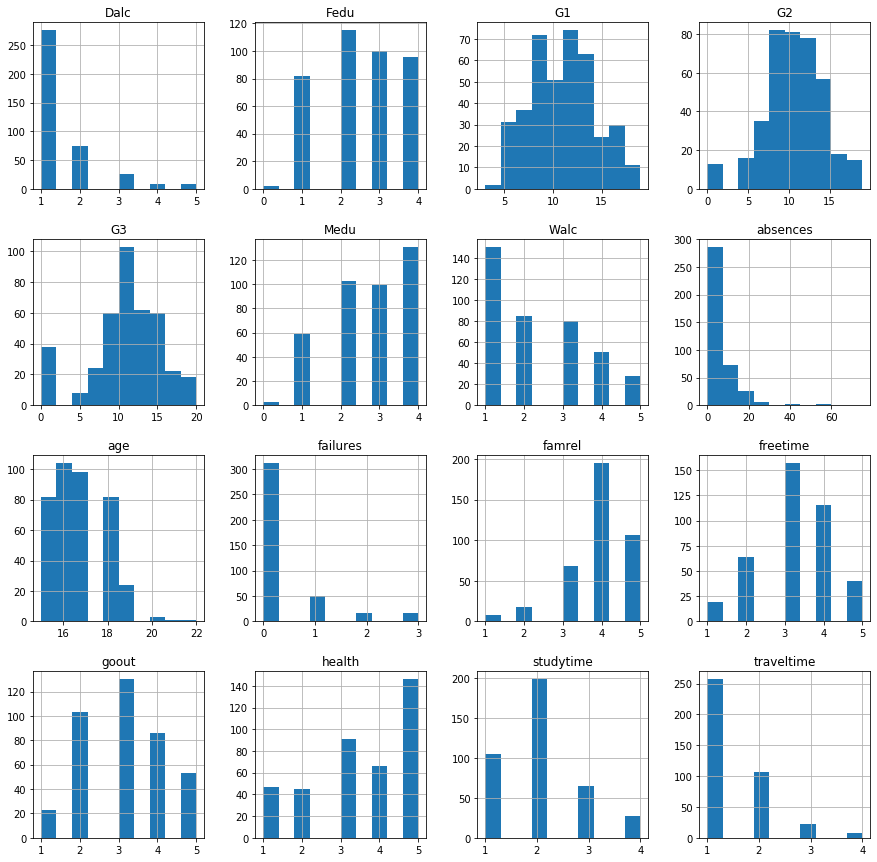

In [7]:
# show hist for numeric
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
dfNum.hist(ax = ax)

In [8]:
# is it corresct????
dfNumStat[dfNumStat['norm_dist'] == True]

,unique_val,mode,mode_freq,mean,median,std,IQR,min,max,Skewness,Kurtosis,norm_dist
age,8,16,104,16.6962,17,1.27604,2,15,22,0.466270,-0.001222,True
studytime,4,2,198,2.03544,2,0.83924,1,1,4,0.632142,-0.014432,True
goout,5,3,130,3.10886,3,1.11328,2,1,5,0.116502,-0.770250,True
G1,17,10,51,10.9089,11,3.31919,5,3,19,0.240613,-0.693830,True
G2,17,9,50,10.7139,11,3.7615,4,0,19,-0.431645,0.627706,True
G3,18,10,56,10.4152,11,4.58144,6,0,20,-0.732672,0.403421,True


## Nominal attributes distribution

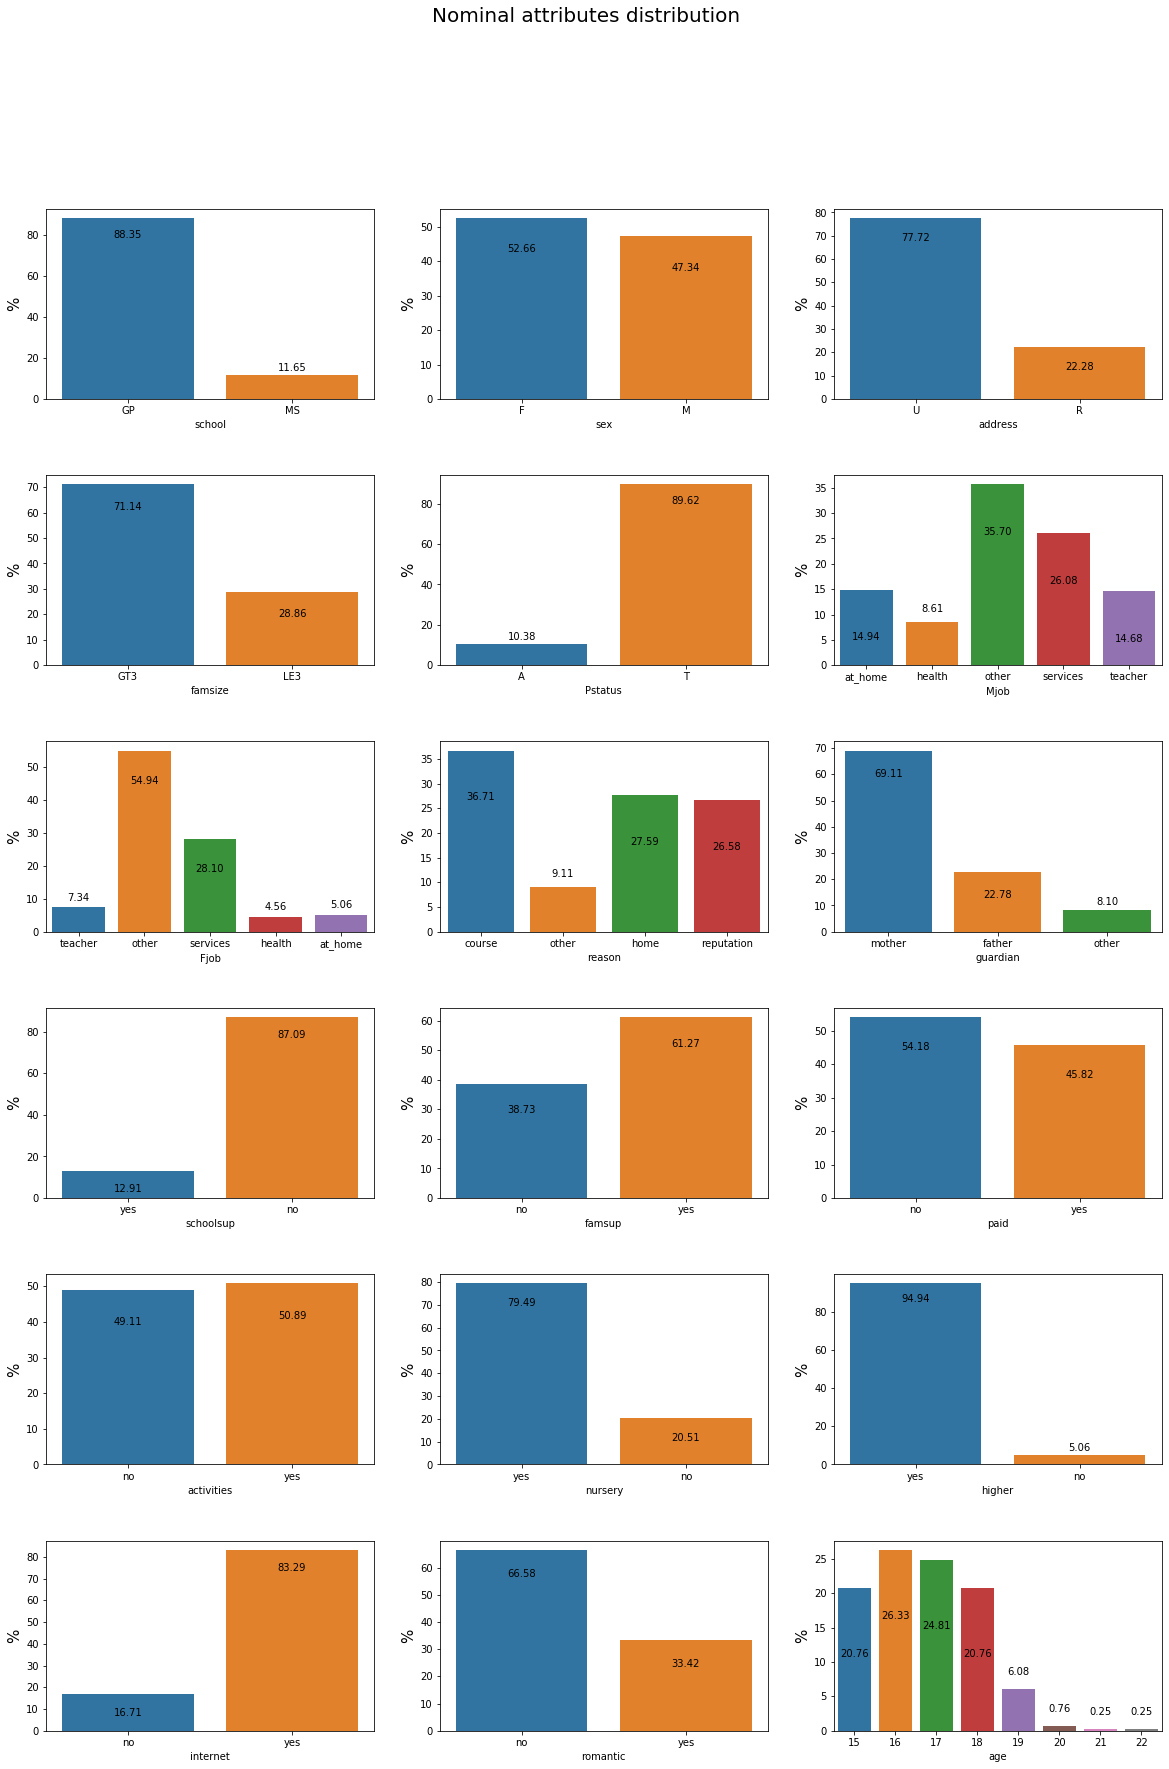

In [9]:
fig,ax = plt.subplots(6,3,figsize=(20,28))
fig.suptitle('Nominal attributes distribution',fontsize=20)
fig.subplots_adjust(hspace=.4)
for ind,col in enumerate(dfNom.columns[:18]):
    sns.barplot(x = col, y = 'age', data = dfNom, ax = ax.flatten()[ind],estimator=lambda x: len(x) / len(dfNom) * 100)

[x.set_ylabel('%',fontsize = 15) for x in ax.flatten()]

def show_values_on_bars(axs):
    #Utility for showing values on bars
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            if p.get_height() < 12:
                _y =  p.get_height() + 2
            else:
                _y = p.get_height() - 10
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        

for ax_ in ax.ravel():
    show_values_on_bars(ax_)

## Ordinal attributes distribution

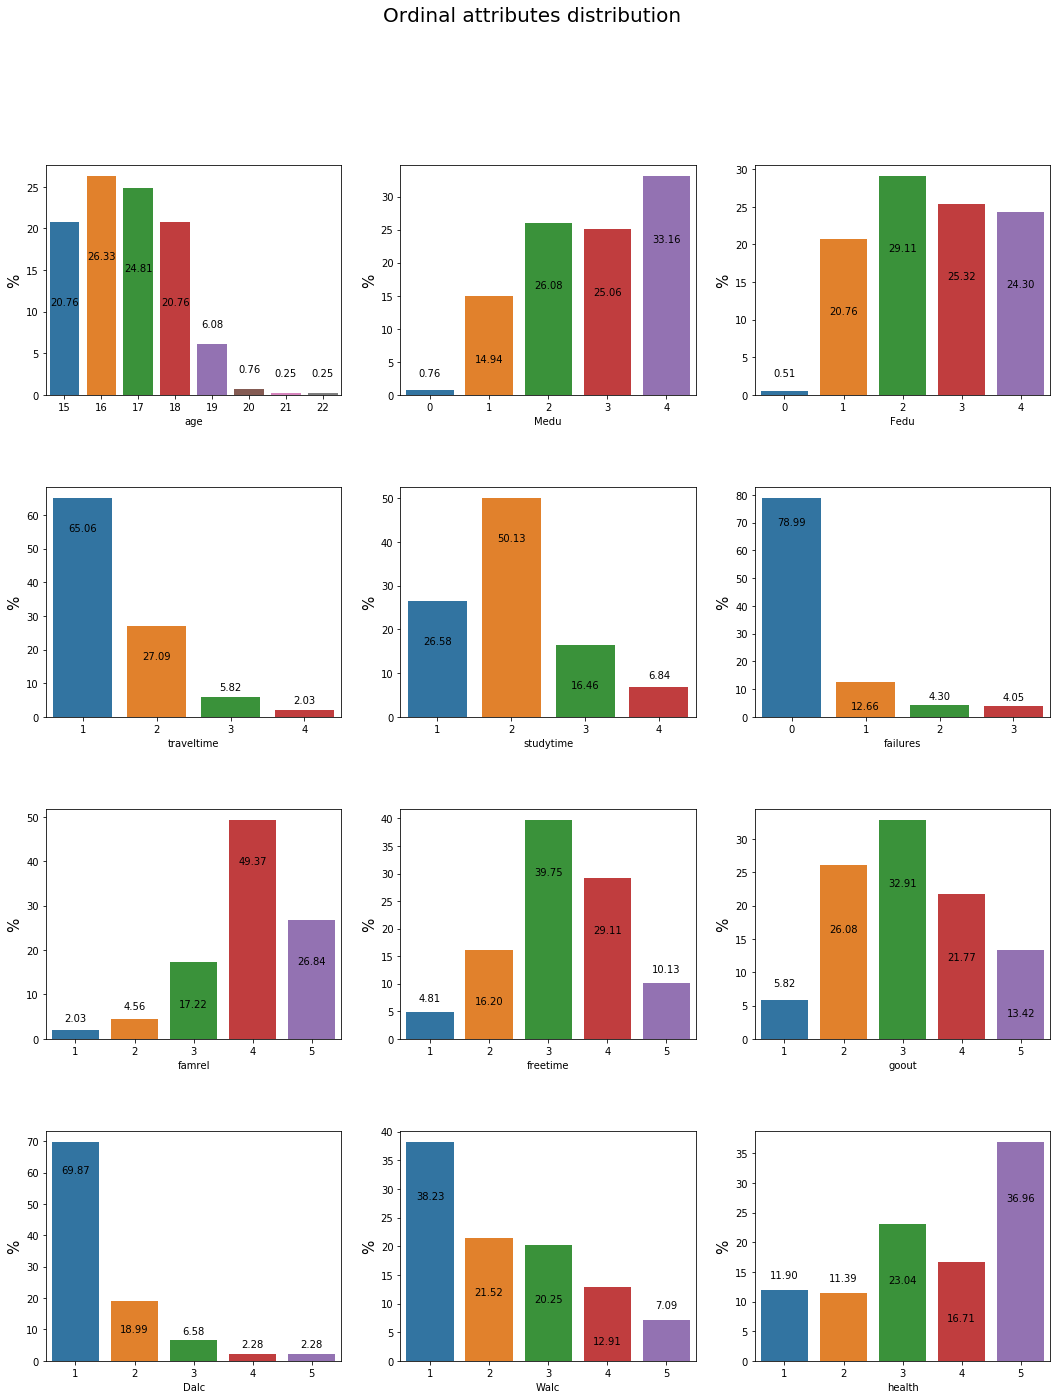

In [10]:
fig,ax = plt.subplots(4,3,figsize=(18,22))
fig.suptitle('Ordinal attributes distribution',fontsize=20)
fig.subplots_adjust(hspace=.4)
for ind,col in enumerate(dfOrd.columns[:18]):
    sns.barplot(x = col, y = 'age', data = dfOrd, ax = ax.flatten()[ind],estimator=lambda x: len(x) / len(dfOrd) * 100)

[x.set_ylabel('%',fontsize = 15) for x in ax.flatten()]

for ax_ in ax.ravel():
    show_values_on_bars(ax_)

## Correlation tests:

### Matrix

In [11]:
# change data for numeric
# binary
new_df = df.replace({'yes': 1, 'no': 0})

# categories
new_df = pd.get_dummies(new_df)





# plt.figure(figsize=(20,28))
# # plot corr
# ax = sns.heatmap(new_df.corr(), center=0, fmt='.0%', linewidths=0.2, annot=True, cmap='RdBu_r')

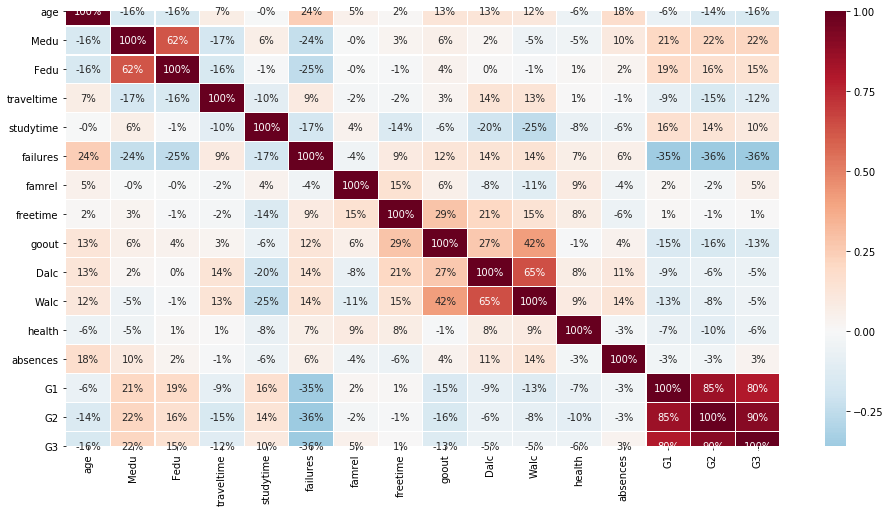

In [12]:
plt.figure(figsize=(16,8))
# plot corr
ax = sns.heatmap(dfNum.corr(), center=0, fmt='.0%', linewidths=0.2, annot=True, cmap='RdBu_r')

## Numeric attributes correlation by r-Pearson

Необходимо помнить, что коэффициент корреляции Пирсона основан на следующих важных допущениях:

* Обе анализируемые переменные распределены нормально
* Связь между этими переменными линейна

Для исправления ситуации можно попробовать логарифмировать обе переменные.

In [13]:
# feature with normal dist
dfNumStat[dfNumStat['norm_dist'] == True]

,unique_val,mode,mode_freq,mean,median,std,IQR,min,max,Skewness,Kurtosis,norm_dist
age,8,16,104,16.6962,17,1.27604,2,15,22,0.466270,-0.001222,True
studytime,4,2,198,2.03544,2,0.83924,1,1,4,0.632142,-0.014432,True
goout,5,3,130,3.10886,3,1.11328,2,1,5,0.116502,-0.770250,True
G1,17,10,51,10.9089,11,3.31919,5,3,19,0.240613,-0.693830,True
G2,17,9,50,10.7139,11,3.7615,4,0,19,-0.431645,0.627706,True
G3,18,10,56,10.4152,11,4.58144,6,0,20,-0.732672,0.403421,True


In [14]:
feature_check_pearson = dfNumStat[dfNumStat['norm_dist'] == True].index.tolist()
feature_check_pearson

['age', 'studytime', 'goout', 'G1', 'G2', 'G3']

In [15]:
import itertools

all_combianation = []

c = list(itertools.product(feature_check_pearson, feature_check_pearson))
for _ in c:
    o = list(_)
    if o[0] != o[1]:
        all_combianation.append(list(_))

# drop duplicates
for _ in all_combianation:
    val = _[0]+_[1]
    for el in all_combianation:
        check = el[1]+el[0]
        if val == check: all_combianation.pop(all_combianation.index(_))

            
# TO DO: drop all pairs without linear coorelation!!!
all_combianation_pearson = all_combianation
all_combianation_pearson

[['age', 'goout'],
 ['age', 'G2'],
 ['studytime', 'age'],
 ['studytime', 'G1'],
 ['studytime', 'G3'],
 ['goout', 'studytime'],
 ['goout', 'G2'],
 ['G1', 'age'],
 ['G1', 'goout'],
 ['G1', 'G3'],
 ['G2', 'studytime'],
 ['G2', 'G1'],
 ['G3', 'age'],
 ['G3', 'goout'],
 ['G3', 'G2']]

In [16]:
# make a dict with values
corr_dict = {'weak_positive_relationship': 0.3,
'mid_positive_relationship': 0.7,
'strong_positive_relationship': 1,
'weak_negative_relationship': -0.3,
'mid_negative_relationship': -0.7,
'strong_negative_relationship': -1,
'low_statistical_significance': 0.05,
'mid_statistical_significance': 0.01,
'strong_statistical_significance': 0.001}

In [17]:
# print value by key
print(corr_dict['low_statistical_significance'],
# print some keys      
      list(corr_dict.keys())[:4],
# print all values
      corr_dict.values(),
# separate print function
      sep='\n\n')

0.05

['weak_positive_relationship', 'mid_positive_relationship', 'strong_positive_relationship', 'weak_negative_relationship']

dict_values([0.3, 0.7, 1, -0.3, -0.7, -1, 0.05, 0.01, 0.001])


In [18]:
# create empty DF:
corr_df = pd.DataFrame(columns=['Atribut_1', 'Atribut_2', 'corr_est_method','koef','stat_sign','stat_sign_relation'])

Features age and goout
Pearson k-corr: 0.12696387964294437, p-value:0.011550462227816872
weak_positive_relationship
low_statistical_significance


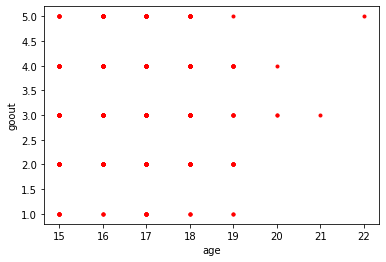

Features age and G2
Pearson k-corr: -0.14347404903545952, p-value:0.004273293307291153
weak_negative_relationship
mid_statistical_significance


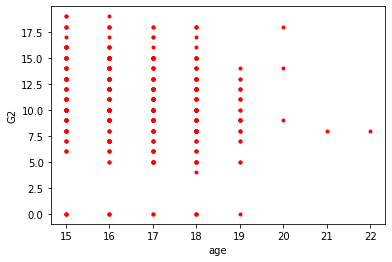

Features studytime and age
Pearson k-corr: -0.004140036816186272, p-value:0.9346298622418879
error
NO statistical significance


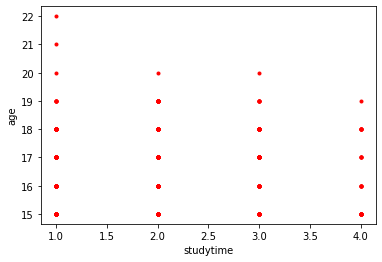

Features studytime and G1
Pearson k-corr: 0.1606119154546958, p-value:0.0013609876023302405
weak_positive_relationship
mid_statistical_significance


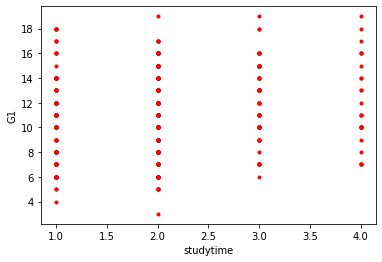

Features studytime and G3
Pearson k-corr: 0.09781968965319622, p-value:0.05206115462063121
weak_positive_relationship
NO statistical significance


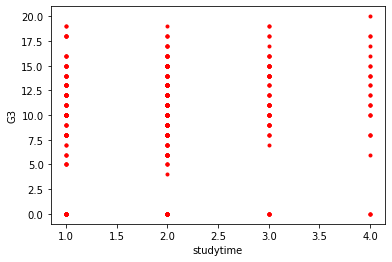

Features goout and studytime
Pearson k-corr: -0.06390367501441137, p-value:0.20503694625965604
weak_negative_relationship
NO statistical significance


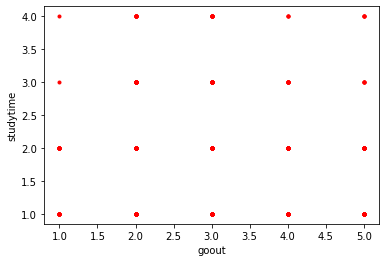

Features goout and G2
Pearson k-corr: -0.16225003415973258, p-value:0.0012125862043052822
weak_negative_relationship
mid_statistical_significance


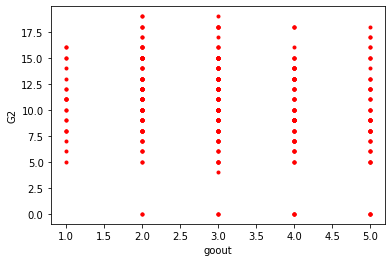

Features G1 and age
Pearson k-corr: -0.06408149744707377, p-value:0.20377673213681416
weak_negative_relationship
NO statistical significance


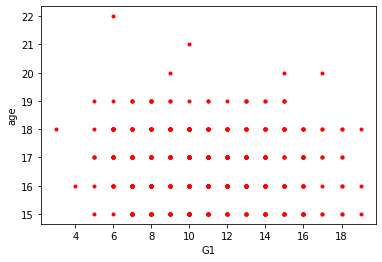

Features G1 and goout
Pearson k-corr: -0.14910396678770718, p-value:0.00297205274412069
weak_negative_relationship
mid_statistical_significance


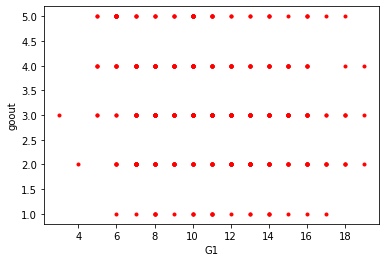

Features G1 and G3
Pearson k-corr: 0.8014679320174141, p-value:9.001430312276602e-90
strong_positive_relationship
strong_statistical_significance


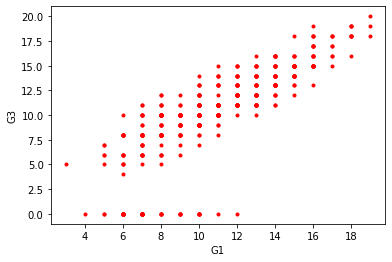

Features G2 and studytime
Pearson k-corr: 0.13587999921449026, p-value:0.006839545304774021
weak_positive_relationship
mid_statistical_significance


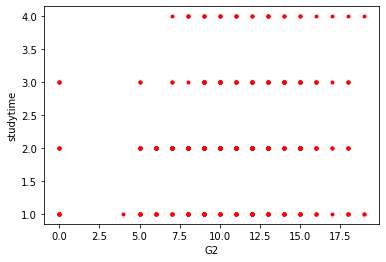

Features G2 and G1
Pearson k-corr: 0.8521180663648062, p-value:1.441346685428264e-112
strong_positive_relationship
strong_statistical_significance


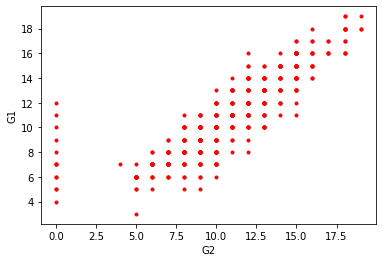

Features G3 and age
Pearson k-corr: -0.16157943813834016, p-value:0.0012714385457178665
weak_negative_relationship
mid_statistical_significance


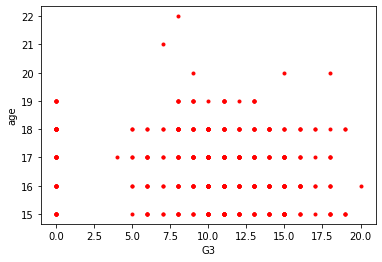

Features G3 and goout
Pearson k-corr: -0.13279147350332907, p-value:0.008229000450140671
weak_negative_relationship
mid_statistical_significance


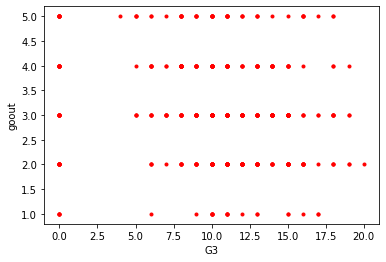

Features G3 and G2
Pearson k-corr: 0.9048679892693012, p-value:7.62571915404493e-148
strong_positive_relationship
strong_statistical_significance


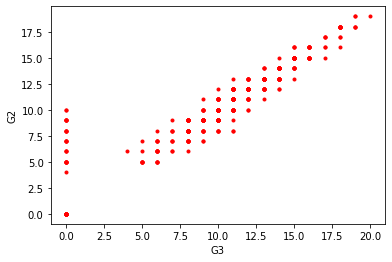

In [19]:
from scipy.stats import pearsonr

for _ in all_combianation_pearson:
# create var:
    a, b = dfNum[_[0]], dfNum[_[1]]
# compute:
    corr, p_val = pearsonr(a,b)
    
  
    print(f'Features {_[0]} and {_[1]}\nPearson k-corr: {corr}, p-value:{p_val}')
    
# just del or comments(#) to drop conclusion:       
    if corr < corr_dict['mid_negative_relationship']:
        print('strong_negative_relationship')
    elif  corr_dict['strong_negative_relationship'] < corr <= corr_dict['mid_negative_relationship']:
        print('mid_negative_relationship')
    elif corr_dict['weak_negative_relationship'] <= corr < -0.01:
        print('weak_negative_relationship')
    elif 0.01 < corr <= corr_dict['weak_positive_relationship']:
        print('weak_positive_relationship')
    elif corr_dict['weak_positive_relationship'] < corr <= corr_dict['mid_positive_relationship']:
        print('mid_positive_relationship')
    elif corr > corr_dict['mid_positive_relationship']:
        print('strong_positive_relationship')
    else: print('error')

# compute a `stat_sign_relation`:
    q = 'yes'
    if corr_dict['strong_statistical_significance'] >= p_val:
        print('strong_statistical_significance')
    elif corr_dict['mid_statistical_significance'] >= p_val > corr_dict['strong_statistical_significance']:
        print('mid_statistical_significance')
    elif p_val < corr_dict['low_statistical_significance']:
        print('low_statistical_significance')
    else: q = 'no'
    if q == 'no': print('NO statistical significance')

# create rows in table:
    corr_df = corr_df.append({'Atribut_1': _[0],
                          'Atribut_2': _[1],
                          'corr_est_method': 'r-Pearson',
                          'koef': corr,
                          'stat_sign': p_val,
                          'stat_sign_relation': q},
                          ignore_index=True)
  


    # just del or comments(#) to drop plots:
    plt.plot(a, b, 'r.')
    plt.xlabel(_[0])
    plt.ylabel(_[1])
    plt.show()

In [20]:
corr_df[corr_df['stat_sign_relation'] == 'yes']

,Atribut_1,Atribut_2,corr_est_method,koef,stat_sign,stat_sign_relation
0,age,goout,r-Pearson,0.126964,1.155046e-02,yes
1,age,G2,r-Pearson,-0.143474,4.273293e-03,yes
3,studytime,G1,r-Pearson,0.160612,1.360988e-03,yes
6,goout,G2,r-Pearson,-0.162250,1.212586e-03,yes
8,G1,goout,r-Pearson,-0.149104,2.972053e-03,yes
9,G1,G3,r-Pearson,0.801468,9.001430e-90,yes
10,G2,studytime,r-Pearson,0.135880,6.839545e-03,yes
11,G2,G1,r-Pearson,0.852118,1.441347e-112,yes
12,G3,age,r-Pearson,-0.161579,1.271439e-03,yes
13,G3,goout,r-Pearson,-0.132791,8.229000e-03,yes


## Numeric attributes correlation by r-Spearman

Для ненормально распределенных переменных, а также при наличии нелинейной связи между переменными, следует использовать непараметрический коэффициент корреляции Спирмена (англ. Spearman correlation coefficient). В отличие от коэффициента Пирсона, этот вариант коэффициента корреляции работает не с исходными значениями переменных, а с их рангами.

In [21]:
feature_check_spearman = dfNumStat.index.tolist()

all_combianation = []

c = list(itertools.product(feature_check_spearman, feature_check_spearman))
for _ in c:
    o = list(_)
    if o[0] != o[1]:
        all_combianation.append(list(_))

# drop duplicates
for _ in all_combianation:
    val = _[0]+_[1]
    for el in all_combianation:
        check = el[1]+el[0]
        if val == check: all_combianation.pop(all_combianation.index(_))

            

all_combianation_spearman = all_combianation

# drop all pairs from `all_combianation_pearson`
all_combianation_spearman = [item for item in all_combianation_spearman if item not in all_combianation_pearson]

In [22]:
print(f'Total pairs:{len(all_combianation_spearman)}:\n\n', all_combianation_spearman)

Total pairs:110:

 [['age', 'Fedu'], ['age', 'studytime'], ['age', 'famrel'], ['age', 'Walc'], ['age', 'absences'], ['Medu', 'age'], ['Medu', 'traveltime'], ['Medu', 'failures'], ['Medu', 'freetime'], ['Medu', 'Dalc'], ['Medu', 'health'], ['Medu', 'G1'], ['Medu', 'G3'], ['Fedu', 'Medu'], ['Fedu', 'studytime'], ['Fedu', 'famrel'], ['Fedu', 'goout'], ['Fedu', 'Walc'], ['Fedu', 'absences'], ['Fedu', 'G2'], ['traveltime', 'age'], ['traveltime', 'Fedu'], ['traveltime', 'failures'], ['traveltime', 'freetime'], ['traveltime', 'Dalc'], ['traveltime', 'health'], ['traveltime', 'G1'], ['traveltime', 'G3'], ['studytime', 'Medu'], ['studytime', 'traveltime'], ['studytime', 'famrel'], ['studytime', 'goout'], ['studytime', 'Walc'], ['studytime', 'absences'], ['studytime', 'G2'], ['failures', 'age'], ['failures', 'Fedu'], ['failures', 'studytime'], ['failures', 'freetime'], ['failures', 'Dalc'], ['failures', 'health'], ['failures', 'G1'], ['failures', 'G3'], ['famrel', 'Medu'], ['famrel', 'traveltime

In [23]:
from scipy.stats import spearmanr
for _ in all_combianation_spearman:
    
    a, b = dfNum[_[0]], dfNum[_[1]]
    
    corr, p_val = spearmanr(a,b)    

    if corr_dict['strong_statistical_significance'] >= p_val:
        q = 'yes'
    elif corr_dict['mid_statistical_significance'] >= p_val > corr_dict['strong_statistical_significance']:
        q = 'yes'
    elif p_val < corr_dict['low_statistical_significance']:
        q = 'yes'
    else: q = 'no'
            
    corr_df = corr_df.append({'Atribut_1': _[0],
                          'Atribut_2': _[1],
                          'corr_est_method': 'r-Spearman',
                          'koef': corr,
                          'stat_sign': p_val,
                          'stat_sign_relation': q},
                          ignore_index=True)
    
# just round koef to float (0.003)
corr_df.koef = corr_df.koef.round(decimals=3)

In [24]:
# count match by `stat_sign_relation`
match = corr_df[corr_df['stat_sign_relation'] == 'yes']
corr_p = corr_df[(corr_df['corr_est_method'] == 'r-Pearson') & (corr_df['stat_sign_relation'] == 'yes')]
corr_s = corr_df[(corr_df['corr_est_method'] == 'r-Spearman') & (corr_df['stat_sign_relation'] == 'yes')]
print(f'Observe correlation for {match.shape[0]} of {corr_df.shape[0]} pairs in Numeric attributes.',
     f'{corr_p.shape[0]} by Pearsons, and {corr_s.shape[0]} by Spearman.',
     sep='\n')


# # print all positiv r-Spearman test table
# corr_df[(corr_df['corr_est_method'] == 'r-Spearman') & (corr_df['stat_sign_relation'] == 'yes')]

Observe correlation for 62 of 125 pairs in Numeric attributes.
11 by Pearsons, and 51 by Spearman.


## Nominal attributes correlation by Chi-squared

In [25]:
for _ in dfNom.columns:
    print(_, df[_].unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes']
age [18 17 15 16 19 22 20 21]


In [26]:
nom_atr = dfNom.columns.tolist()
nom_atr

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'age']

In [27]:
# create empty DF:
# chi2_df = pd.DataFrame(columns=['Atribut_1', 'Atribut_2', 'Chi2','stat_sign','stat_sign_relation'])

# func with 3 var as input
# should input only `x`
def chi2_corr(x, df=df, nom_atr=nom_atr):

    for _ in nom_atr:      
# loop by all attributes in 'nom_atr'
            a = np.asarray(df[x])
# a - target
            b = np.asarray(df[_])
# b - iteration by all attributs
            crosstab = pd.crosstab(a,b)
            chi2 = sts.chi2_contingency(crosstab)

# add results in table
            global corr_df
            corr_df = corr_df.append({'Atribut_1': str(x),
                          'Atribut_2': _,
                          'corr_est_method':'Chi-square',
                          'koef': chi2[0],
                          'stat_sign': chi2[1],
                          'stat_sign_relation': ("yes" if chi2[1] <= 0.05  else "no")},
                          ignore_index=True)

In [28]:
# check 'G3' and 'reason'
chi2_corr('G3')
chi2_corr('reason')

In [29]:
corr_df[(corr_df['corr_est_method'] == 'Chi-square')&(corr_df['stat_sign_relation'] == 'yes')]

,Atribut_1,Atribut_2,corr_est_method,koef,stat_sign,stat_sign_relation
130,G3,Mjob,Chi-square,91.942298,2.821626e-02,yes
134,G3,schoolsup,Chi-square,32.517477,1.296725e-02,yes
136,G3,paid,Chi-square,29.772479,2.803335e-02,yes
141,G3,romantic,Chi-square,30.172482,2.512766e-02,yes
143,reason,school,Chi-square,12.465325,5.947834e-03,yes
145,reason,address,Chi-square,9.648347,2.180446e-02,yes
148,reason,Mjob,Chi-square,22.946282,2.818547e-02,yes
150,reason,reason,Chi-square,1185.000000,2.098230e-249,yes
154,reason,paid,Chi-square,12.052192,7.206495e-03,yes
157,reason,higher,Chi-square,10.237433,1.665203e-02,yes


In [30]:
# func to show boxplots for target with all futeres in atr
def plot_2_var(target, atr):

# figure params
    fig,ax = plt.subplots(6,3,figsize=(20,30))
    fig.suptitle('Boxplots for visualization 2 var relationship',fontsize=20)
    fig.subplots_adjust(hspace=.4)

# loop
    for ind,col in enumerate(atr):
        
# determine target
        sns.boxplot(x = col, y = target, data = df, ax = ax.flatten()[ind])
    
# labels params:
    [x.set_xlabel(atr[ind],fontsize = 15) for ind,x in enumerate(ax.flatten())];
    [x.set_ylabel('G3',fontsize = 15) if ind%4 == 0 else x.set_ylabel('',fontsize = 15) for ind,x in enumerate(ax.flatten())];

# apply `show_values_on_bars` for thicks vizualization:
    for ax_ in ax.ravel():
        show_values_on_bars(ax_)

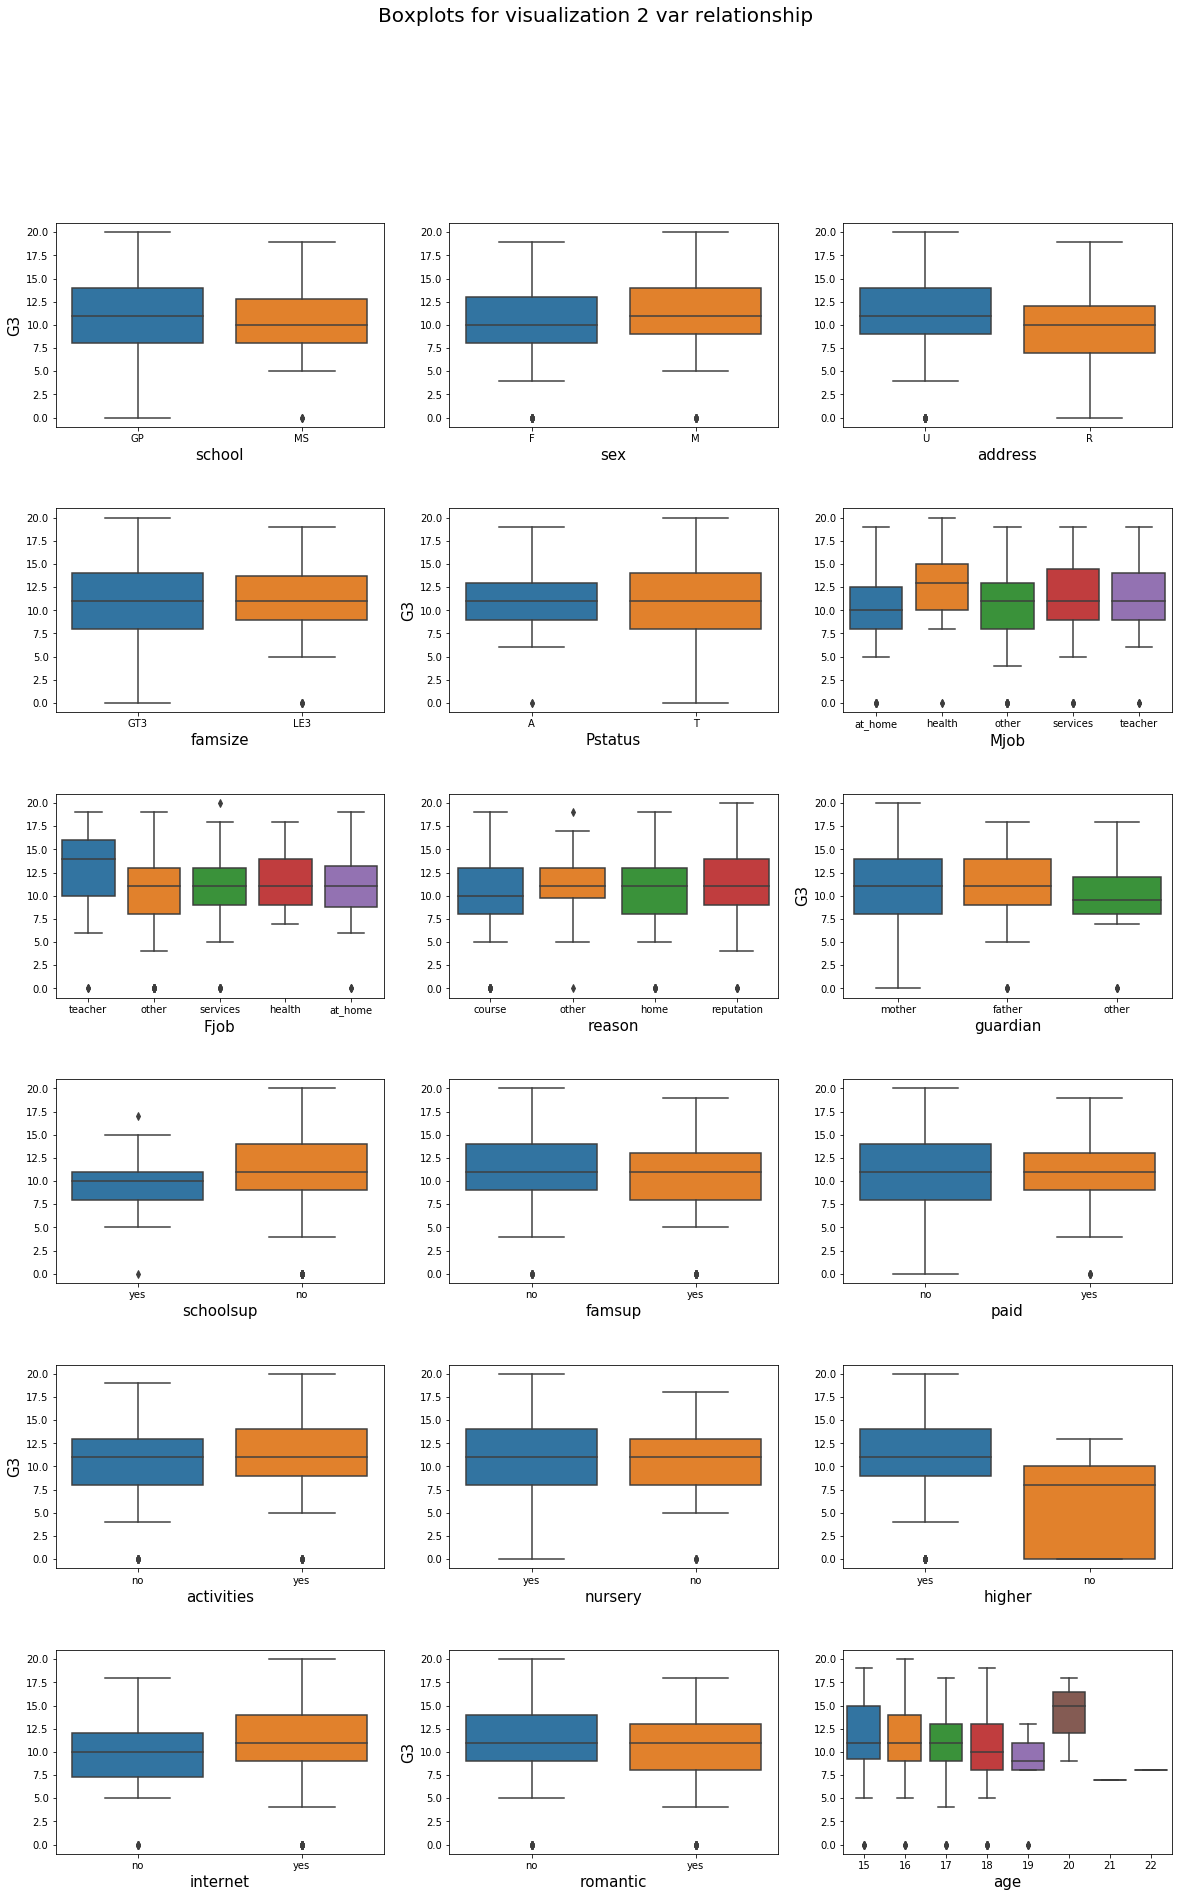

In [31]:
atr = list(dfNom.columns)
# `atr` can be a list-like = ['Mjob', 'sex', 'age'] is it need

# # plot for 'G3' and dfNom columns
plot_2_var('G3', atr)

# # plot for 'reason' and dfNom columns
# plot_2_var('reason', atr)

## T-tests:

ниже общая практика и примеры, обратите внимание, что каждый метод используется для характерного набора данных и **имеет ограничения в применении**:

In [32]:
# just recall an attributes with normal distribution
dfNumStat[dfNumStat['norm_dist'] == True].index

Index(['age', 'studytime', 'goout', 'G1', 'G2', 'G3'], dtype='object')

#### Гипотеза №1: полагаем, что мальчики и девочки одинаково хорошо справились с первой аттестацией:

In [33]:
# выборка данных
m_g1=df[df["sex"]=="M"]["G1"]
f_g1=df[df["sex"]=="F"]["G1"]
m_g1.shape, f_g1.shape

((187,), (208,))

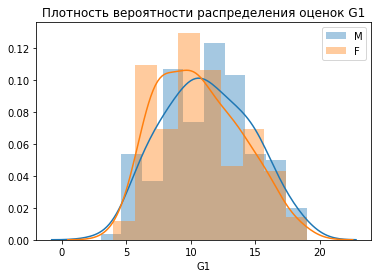

In [34]:
# визуализация распределния - близко к нормальному
sns.distplot(m_g1)
sns.distplot(f_g1)

plt.title('Плотность вероятности распределения оценок G1')
plt.legend(['M', 'F'])
plt.show()

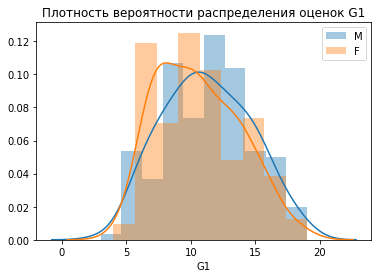

In [35]:
# уравновешенная выборка
sns.distplot(m_g1)

# get `m_g1` same size sample
sns.distplot(f_g1.sample(187))

plt.title('Плотность вероятности распределения оценок G1')
plt.legend(['M', 'F'])
plt.show()

In [36]:
sts.ttest_ind(m_g1, f_g1)

Ttest_indResult(statistic=1.8283673434285317, pvalue=0.06825227168840965)

t-значение - это вероятность того, что различия между выборками также означают разные значения в выборках. Чем выше t, тем более различны группы между собой. Чем меньше t, тем более похожи группы и результаты повторятся. 


**В Гипотеза №1:**
t-value(`statistic=1.82836`) и `pvalue` **больше стандартной альфа ошибки 0.05**, поэтому мы принимаем нулевую гипотезу и можем сказать, что не имеется статистическое различие между оценками мальчиков и девочек на этапе G1.

**ВАЖНО: если мы сравниваем какую-то часть выборки и всю генеральную совокупность, необходимо больше внимания уделить праметру `t-value` и его [доверительному интервалу.](http://old.exponenta.ru/educat/referat/XIkonkurs/student5/tabt-st.pdf) об этом Гипотеза №2.**

#### Гипотеза №2: полагаем, что те кто ходил в детский сад(`nursery`), имеют привычку прогуливать как вся совокупность учеников.

In [37]:
# выборка данных
nurs_n = df[df["nursery"]=="no"]["absences"]
nurs_n.shape

(81,)

In [38]:
# 2nd arg is mean value from total
sts.ttest_1samp(nurs_n, df["absences"].mean())

Ttest_1sampResult(statistic=-0.2847690511911155, pvalue=0.7765569603270004)

Так как значение t-value не превышает [табличного значения доверительного интервала](http://old.exponenta.ru/educat/referat/XIkonkurs/student5/tabt-st.pdf), то мы принимаем нулевую гипотезу (о том, что средние значения выборок равны).

Так же можно оценивать p-value. Вероятность получить такое (либо большее) значение t при условии, что проверяемая нулевая гипотеза верна, оказалась весьма велика: p-value = 0.77 (это больше 5%), поэтому мы принимаем нулевую гипотезу и можем сказать, что отсутствует статистическое различие между прогулами тех, кто ходил в детсад и генеральной совокупности в целом.

#### Однако, если данные не распределены нормально (как здесь), нужен критерий Манна-Уитни. Чем меньше значение критерия, тем вероятнее, что различия между значениями параметра в выборках достоверны.

Критерий Манна-Уитни дает больше информации о различии выборок.

**У метода есть ограничения:**

1. В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
2. В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

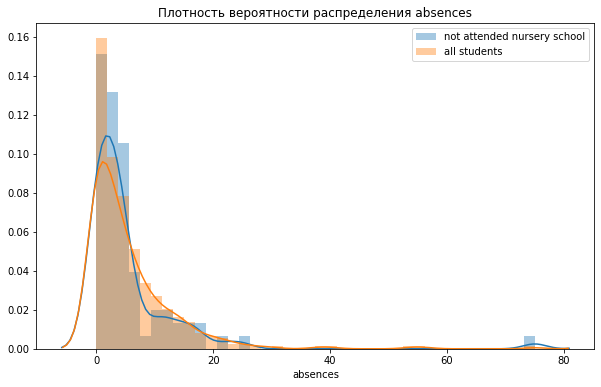

In [39]:
rcParams['figure.figsize'] = 10,6
sns.distplot(nurs_n, 40)
sns.distplot(df['absences'], 40)
plt.title('Плотность вероятности распределения absences')
plt.legend(['not attended nursery school', 'all students'])
plt.show()

In [40]:
sts.mannwhitneyu(nurs_n, df['absences'])

MannwhitneyuResult(statistic=15308.5, pvalue=0.2674668964985769)

#### Conlusion: ...........

In [41]:
# equal samples
random_81_students = df['absences'].sample(81)
sts.mannwhitneyu(nurs_n, random_81_students)

MannwhitneyuResult(statistic=3153.0, pvalue=0.33241730305437256)

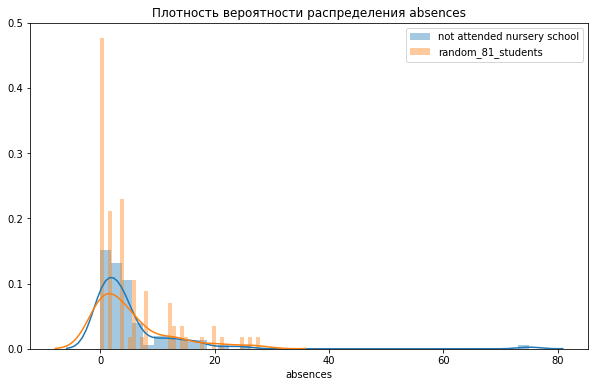

In [42]:
rcParams['figure.figsize'] = 10,6
sns.distplot(nurs_n, 40)
sns.distplot(df['absences'].sample(81), 40)
plt.title('Плотность вероятности распределения absences')
plt.legend(['not attended nursery school', 'random_81_students'])
plt.show()

## `ANOVA`
#### Гипотеза №3: ученики с различным признаком `guardian == ['mother' 'father' 'other']` в целом одинаково справляются с итоговым тестированием.

Если мы хотим оценить не две группы, а три и более, нужно использовать множественное тестирование `ANOVA`:

In [43]:
g1_by_m = df[df['guardian']=='mother']['G1']

g1_by_f = df[df['guardian']=='father']['G1']

g1_by_o = df[df['guardian']=='other']['G1']

##### Необходимо, чтобы распределение внутри групп было нормальным. Посмотрим:

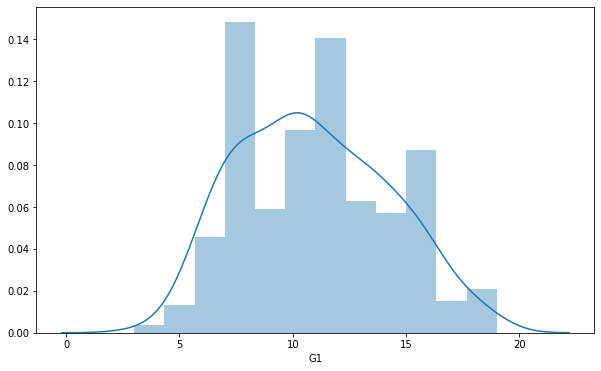

In [44]:
# all students - normal distribution
sns.distplot(df.G1)

Students in sample: 273, 90, 32


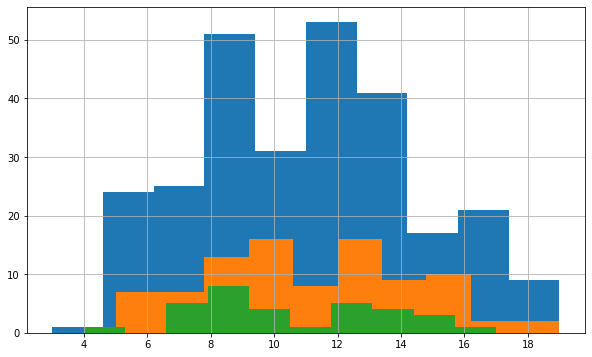

In [45]:
print(f'Students in sample: {g1_by_m.shape[0]}, {g1_by_f.shape[0]}, {g1_by_o.shape[0]}')
g1_by_m.hist()
g1_by_f.hist()
g1_by_o.hist()

# or:
# print(f'Students in sample: {g3_by_m.shape[0]}, {g3_by_f.shape[0]}, {g3_by_o.shape[0]}.')
# rcParams['figure.figsize'] = 10,6
# sns.distplot(g1_by_m)
# sns.distplot(g1_by_f)
# sns.distplot(g1_by_o)

In [46]:
sts.f_oneway(g1_by_m, g1_by_f, g1_by_o)

F_onewayResult(statistic=0.34857472001769446, pvalue=0.7059116951618062)

#### Так как результат p-value больше 0.05, то мы не можем отвергнуть нулевую гипотезу о схожести групп с разным признаком `guardian`.

### `Kruskal–Wallis`
непараметрический аналог теста `ANOVA`

#### Гипотеза №4: медианное значение `failures` одинаково для учеников разного пола:

In [47]:
first_attr = 'sex'
non_norm_distr_atr = 'failures'
list(df[non_norm_distr_atr].unique())

[0, 3, 2, 1]

In [48]:
def KW(first_attr=first_attr, non_norm_distr_atr=non_norm_distr_atr, df=df):
    
    # create empty list fo data
    new_list = []
    
# create a loop from all unique in 'failures'
    for _ in df[first_attr].unique():  
        one_df = df[df[first_attr]==_][non_norm_distr_atr]
        print(f'\nTotal: {len(one_df)}')
        new_list.append(one_df)
        one_df.hist()
        for i in list(df[non_norm_distr_atr].unique()):
            print(f'{_} with {i} failures:',
                df[(df[non_norm_distr_atr]==i)&(df[first_attr]==_)].count()[0])
    print(sts.kruskal(*new_list))


Total: 208
F with 0 failures: 168
F with 3 failures: 6
F with 2 failures: 11
F with 1 failures: 23

Total: 187
M with 0 failures: 144
M with 3 failures: 10
M with 2 failures: 6
M with 1 failures: 27
KruskalResult(statistic=0.8075023209148101, pvalue=0.36885972210576456)


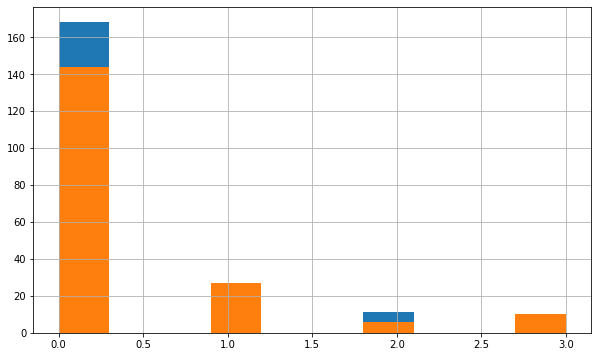

In [49]:
KW(first_attr, non_norm_distr_atr, df)

#### Conlusion: ...........

### Table and plot:

In [50]:
# create empty DF:
t_test_df = pd.DataFrame(columns=['Atribut_1', 'Atribut_2', 'test_name', 'test_value',
                                  'Atribut_2_norm_dist', 'stat_sign','stat_sign_relation'])

def t_test_checker(attr_1, attr_2, method, df=df):
# func recive 2 series/arrays , examples:
# attr_1 = df[df['age'] == 18]['G1']
# attr_2 = df['absence'] 

# and method from dict:

# 'T-ind' = sts.ttest_ind(),
# 'T-same' = sts.ttest_1samp(),
# 'MW' = sts.mannwhitneyu(),
# 'ANOVA' = sts.f_oneway(),
# 'KW' = sts.kruskal().

##################################
    global t_test_df
    new_list = []

# distribution checker
    if attr_2.name in dfNumStat[dfNumStat['norm_dist'] == True].index:
        norm_dist = True
    else: norm_dist = False

# compute
    try:
        if method == 'T-ind':
            t_val=sts.ttest_ind(attr_1,attr_2)[0]
            p_val=sts.ttest_ind(attr_1,attr_2)[1]

        elif method == 'T-same':
            t_val=sts.ttest_1samp(attr_1,attr_2.mean())[0]
            p_val=sts.ttest_1samp(attr_1,attr_2.mean())[1]

        if method == 'MW':
            t_val=sts.mannwhitneyu(attr_1,attr_2)[0]
            p_val=sts.mannwhitneyu(attr_1,attr_2)[1]

        elif method == 'ANOVA':
            for _ in attr_1.unique():  
                new_sample = df[attr_1==_][attr_2.name]
                new_list.append(new_sample)
            t_val=sts.f_oneway(*new_list)[0]
            p_val=sts.f_oneway(*new_list)[1]

        elif method == 'KW':
            for _ in attr_1.unique():  
                new_sample = df[attr_1==_][attr_2.name]
                new_list.append(new_sample)
            t_val=sts.kruskal(*new_list)[0]
            p_val=sts.kruskal(*new_list)[1]
            
        # debugger  
        else: print('Unkonow mthod, choose one of:','T-ind','T-same', 'MW','ANOVA','KW',sep=' ') 
            
    except AttributeError:
        print('###############################################',
              f'You are using the {method} method incorrectly',
             '###############################################',
             sep='\n')
    except TypeError:
        print('###############################################',
              f'You are using the {method} method incorrectly',
             '###############################################',
             sep='\n')
    except ValueError:
        print('###############################################',
              f'You are using the {method} method incorrectly',
             '###############################################',
             sep='\n')

     
        

    t_test_df = t_test_df.append({'Atribut_1': attr_1.name,
    'Atribut_2': attr_2.name,
    'test_name': method,
    'test_value': t_val,
    'Atribut_2_norm_dist': norm_dist,                             
    'stat_sign': p_val,
    'stat_sign_relation': ("yes" if p_val <= 0.05  else "no")},
    ignore_index=True)

    return t_test_df

#### 1 hipo: Mann-Whitney test for df['Dalc'], df['absences'] - REPLACE!!!

In [51]:
# examples:
# t_test_checker(df[df['Medu']==1]['age'], df['age'], 'T-same')
# t_test_checker(df['G3'], df['age'], 'T-ind')
# t_test_checker(df['Fjob'], df['G1'], 'ANOVA')

# run func:
t_test_checker(df['Dalc'], df['absences'], 'MW')

,Atribut_1,Atribut_2,test_name,test_value,Atribut_2_norm_dist,stat_sign,stat_sign_relation
0,Dalc,absences,MW,52479.5,False,1.385347e-16,yes


### Гипотеза №2: ученики с различным признаком Mjob ['at_home' 'health' 'other' 'services' 'teacher'] одинаково проводят время вне дома.


In [126]:
home = df[df['Mjob']=='at_home']['goout']

health = df[df['Mjob']=='health']['goout']

other = df[df['Mjob']=='other']['goout']

serv = df[df['Mjob']=='services']['goout']



# sts.f_oneway(home, health, other, serv, teacher)

# SAME:

# compute by func
t_test_checker(df['Mjob'], df['goout'], 'ANOVA')

,Atribut_1,Atribut_2,test_name,test_value,Atribut_2_norm_dist,stat_sign,stat_sign_relation
0,Dalc,absences,MW,52479.500000,False,1.385347e-16,yes
1,Mjob,goout,ANOVA,0.508113,True,7.298061e-01,no


### Гипотеза №3: ученики с различным признаком Fjob ['teacher' 'other' 'services' 'health' 'at_home'] одинаково тратят время на обучение (studytime).

In [127]:
home = df[df['Fjob']=='at_home']['studytime']

health = df[df['Fjob']=='health']['studytime']

other = df[df['Fjob']=='other']['studytime']

serv = df[df['Fjob']=='services']['studytime']

teacher = df[df['Fjob']=='teacher']['studytime']

# sts.f_oneway(home, health, other, serv, teacher)

# SAME:

# compute by func
t_test_checker(df['Fjob'], df['studytime'], 'ANOVA')

,Atribut_1,Atribut_2,test_name,test_value,Atribut_2_norm_dist,stat_sign,stat_sign_relation
0,Dalc,absences,MW,52479.500000,False,1.385347e-16,yes
1,Mjob,goout,ANOVA,0.508113,True,7.298061e-01,no
2,Fjob,studytime,ANOVA,1.874794,True,1.140702e-01,no


In [128]:
# table:
t_test_df

,Atribut_1,Atribut_2,test_name,test_value,Atribut_2_norm_dist,stat_sign,stat_sign_relation
0,Dalc,absences,MW,52479.500000,False,1.385347e-16,yes
1,Mjob,goout,ANOVA,0.508113,True,7.298061e-01,no
2,Fjob,studytime,ANOVA,1.874794,True,1.140702e-01,no


### Plot all relationship:

`interval diagram (mean / median ± 95% CI) for each case`

In [130]:
mean = df.mean(axis = 1)
std = df.std(axis = 1)

n= df.shape[1]
yerr = std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)

plt.figure()
plt.bar(range(df.shape[0]), mean, yerr = yerr) 
plt.show() 

In [133]:
data.shape

(100,)

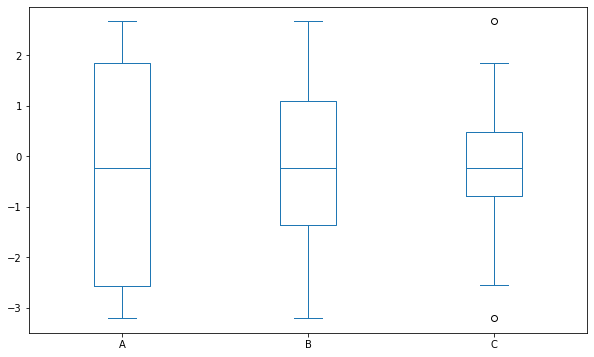

In [131]:
# Generate some random data to visualise
np.random.seed(2019)
data = np.random.normal(size=100)

stats = {}

# Compute the boxplot stats with our desired percentiles
stats['A'] = my_boxplot_stats(data, labels='A', percents=[1, 99])[0]
stats['B'] = my_boxplot_stats(data, labels='B', percents=[10, 90])[0]
stats['C'] = my_boxplot_stats(data, labels='C', percents=[25, 75])[0]

fig, ax = plt.subplots(1, 1)
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

mean = df.mean(axis = 1)
std = df.std(axis = 1)

n= df.shape[1]
yerr = std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)

plt.figure()
plt.bar(range(df.shape[0]), mean, yerr = yerr) 
plt.show() 

### Modeling and optimazing:

In [ ]:
# change data for numeric:

# binary
new_df = df.replace({'yes': 1, 'no': 0})

# categories
new_df = pd.get_dummies(new_df)

In [92]:
# all `G1` correlations relationships
corr_G1 = new_df.corr().loc['G3',:].sort_values(ascending=False)

#### All features because of which a low rating:

In [98]:
corr_G1[corr_G1 < 0]

Fjob_at_home     -0.013385
Fjob_services    -0.016108
reason_home      -0.021359
famsup           -0.039157
school_MS        -0.045017
Walc             -0.051939
Fjob_other       -0.053483
Dalc             -0.054660
Pstatus_T        -0.058009
health           -0.061335
famsize_GT3      -0.081407
schoolsup        -0.082788
guardian_other   -0.087774
Mjob_other       -0.096477
reason_course    -0.098950
sex_F            -0.103456
address_R        -0.105756
Mjob_at_home     -0.115634
traveltime       -0.117142
romantic         -0.129970
goout            -0.132791
age              -0.161579
failures         -0.360415
Name: G3, dtype: float64

#### Let's take a rule: `G3` value less then 11 (median) is underline scores, compute DPMO:

In [55]:
dfStat.loc['G3',:]

mean          10.4152
std           4.58144
min                 0
25%                 8
median             11
75%                14
max                20
mode               10
unique_val         18
mode_freq          56
Name: G3, dtype: object

In [121]:
P = df.shape[0]
D = df[df['G3'] < 11 ].shape[0]

# all fetures with negative correlation
O = corr_G1[corr_G1 < 0].shape[0]

DPM = D / P * O
DPMO = D / P * O * 1000000
print(f'Students with underline scores = {D}(defects), all studens = {P}(products),  features = {O}(opportunity):\n',
      f'DPM = {DPM}',
      f'DPMO = {round(DPMO, 3)}',
      sep='\n')

Students with underline scores = 186(defects), all studens = 395(products),  features = 23(opportunity):

DPM = 10.830379746835444
DPMO = 10830379.747


### Let's try to increase students grade.

In [54]:
# at first create df to predictions target

# drop most correletions futures
df_est = new_df.drop(columns = ['G1','G2'])

df_est.shape

(395, 49)

In [64]:
# create estimator and take a look to quality:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X = df_est.drop(columns = ['G3'])
y = df_est['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .1, shuffle=True)


reg = RandomForestRegressor(max_depth=2, random_state=0)
params = {'max_depth': list(range(3,8,1)),
          'max_features':list(range(4,30,3)),
          'min_samples_leaf':list(range(5,46,10))}


est = GridSearchCV(reg, params)

est.fit(X_train,y_train) 
print(est.best_estimator_)

median_pred = [df['G3'].median() for i in range(len(y_test))]
preds = est.predict(X_test)

print(f'\nRMSE for RF predicions = {np.sqrt(mean_squared_error(y_test, preds))}')

print(f'\nRMSE if all preds is median = {np.sqrt(mean_squared_error(y_test, median_pred))}')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=28, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

RMSE for RF predicions = 4.403784875178496

RMSE if all preds is median = 5.002499375312305


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [65]:
# get feature_importances_ and compare with correlations

RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=28, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
RF.fit(X_train,y_train) 


features = list(X.columns)

importances = RF.feature_importances_
importances = importances.round(3)*100

std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
indices

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f'{f+1}, {features[indices[f]]}, {str(round(importances[indices[f]],3))} %')

Feature ranking:
1, failures, 26.6 %
2, absences, 19.5 %
3, goout, 4.7 %
4, health, 4.4 %
5, age, 3.4 %
6, Medu, 3.2 %
7, Walc, 2.7 %
8, freetime, 2.5 %
9, Fedu, 2.3 %
10, studytime, 2.2 %
11, Pstatus_T, 1.9 %
12, famsup, 1.9 %
13, schoolsup, 1.8 %
14, Fjob_teacher, 1.7 %
15, romantic, 1.6 %
16, famrel, 1.6 %
17, Dalc, 1.6 %
18, sex_F, 1.4 %
19, Mjob_services, 1.4 %
20, traveltime, 1.3 %
21, Mjob_other, 1.0 %
22, Fjob_other, 1.0 %
23, reason_course, 0.9 %
24, paid, 0.9 %
25, activities, 0.9 %
26, reason_reputation, 0.9 %
27, reason_home, 0.9 %
28, Mjob_at_home, 0.8 %
29, school_MS, 0.7 %
30, guardian_other, 0.7 %
31, internet, 0.6 %
32, address_R, 0.5 %
33, sex_M, 0.4 %
34, address_U, 0.4 %
35, Mjob_health, 0.3 %
36, guardian_father, 0.3 %
37, famsize_LE3, 0.3 %
38, guardian_mother, 0.3 %
39, famsize_GT3, 0.3 %
40, reason_other, 0.2 %
41, Mjob_teacher, 0.2 %
42, Fjob_at_home, 0.2 %
43, higher, 0.1 %
44, Pstatus_A, 0.0 %
45, Fjob_services, 0.0 %
46, nursery, 0.0 %
47, school_GP, 0.0 %
4

In [66]:
# check features with `stat_sign_relation`

corr_df[(corr_df['Atribut_1'] == 'G3')&(corr_df['stat_sign_relation'] == 'yes')\
       |(corr_df['Atribut_2'] == 'G3')&(corr_df['stat_sign_relation'] == 'yes')].sort_values(by='koef', ascending=False)

,Atribut_1,Atribut_2,corr_est_method,koef,stat_sign,stat_sign_relation
130,G3,Mjob,Chi-square,91.942298,2.821626e-02,yes
134,G3,schoolsup,Chi-square,32.517477,1.296725e-02,yes
141,G3,romantic,Chi-square,30.172482,2.512766e-02,yes
136,G3,paid,Chi-square,29.772479,2.803335e-02,yes
14,G3,G2,r-Pearson,0.905000,7.625719e-148,yes
9,G1,G3,r-Pearson,0.801000,9.001430e-90,yes
27,Medu,G3,r-Spearman,0.225000,6.290448e-06,yes
120,G3,Fedu,r-Spearman,0.170000,6.895636e-04,yes
121,G3,studytime,r-Spearman,0.105000,3.667358e-02,yes
123,G3,Walc,r-Spearman,-0.104000,3.797038e-02,yes


In [68]:
df.freetime.value_counts()

3    157
4    115
2     64
5     40
1     19
Name: freetime, dtype: int64

In [101]:
# change `freetime`
less_freetime_df = new_df.copy()

# `replace` is a rule 
less_freetime_df['freetime'] = less_freetime_df['freetime'].replace({5: 3, 4: 2, 3:1})
less_freetime_df.freetime.value_counts()

2    179
1    176
3     40
Name: freetime, dtype: int64

In [104]:
# run RF to get new grade

less_freetime_X = less_freetime_df.drop('G3', axis=1)
less_freetime_preds = RF.predict(less_freetime_X)

print(f'RMSE for RF predicions = {np.sqrt(mean_squared_error(df.G3, less_freetime_preds))}')

RMSE for RF predicions = 1.3878399775088213


Low-level students percentage before optimization: 47.0886
Low-level students percentage after optimization: 54.6835


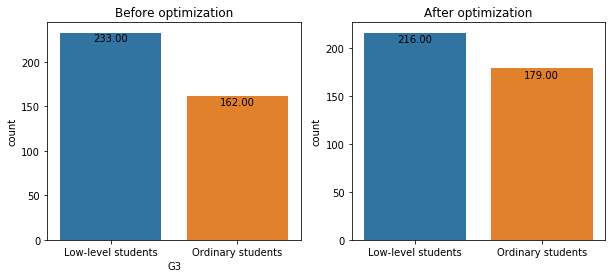

In [109]:
# result

fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.countplot((df.G3 > 11).replace({True:'Ordinary students',False:'Low-level students'}),ax=ax[0])
ax[0].set_title('Before optimization')
sns.countplot(['Ordinary students' if x == True else 'Low-level students' for x in (less_freetime_preds > 11)],ax = ax[1])
ax[1].set_title('After optimization')
for ax_ in ax.flatten():
    show_values_on_bars(ax_)
    
print('Low-level students percentage before optimization: %.4f' % (sum(df.G3 < 11) / df.shape[0] * 100))
print('Low-level students percentage after optimization: %.4f' % (sum(less_freetime_preds < 11) / df.shape[0] * 100))

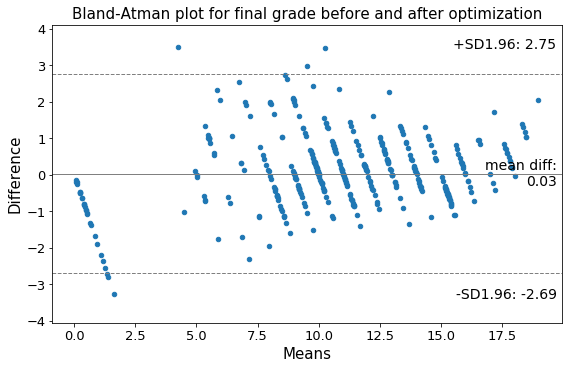

In [108]:
import statsmodels.api as sm

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(df.G3, less_freetime_preds, ax=ax)
ax.set_title('Bland-Atman plot for final grade before and after optimization',fontsize=15)
plt.show()

## hipo 2 - "dry law in the country"

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [111]:
df.Dalc.value_counts(), df.Walc.value_counts()

(1    276
 2     75
 3     26
 5      9
 4      9
 Name: Dalc, dtype: int64, 1    151
 2     85
 3     80
 4     51
 5     28
 Name: Walc, dtype: int64)

In [113]:
no_alco_df = new_df.copy()

# change all to 0
no_alco_df.Dalc = 0
no_alco_df.Walc = 0

no_alco_df.Dalc.value_counts(), no_alco_df.Walc.value_counts()

(0    395
 Name: Dalc, dtype: int64, 0    395
 Name: Walc, dtype: int64)

In [114]:
# run RF to get new grade

no_alco_df_X = no_alco_df.drop('G3', axis=1)
no_alco_df_preds = RF.predict(no_alco_df_X)

print(f'RMSE for RF predicions = {np.sqrt(mean_squared_error(df.G3, no_alco_df_preds))}')

RMSE for RF predicions = 1.4057087510321988


Low-level students percentage before optimization: 47.0886
Low-level students percentage after optimization: 54.9367


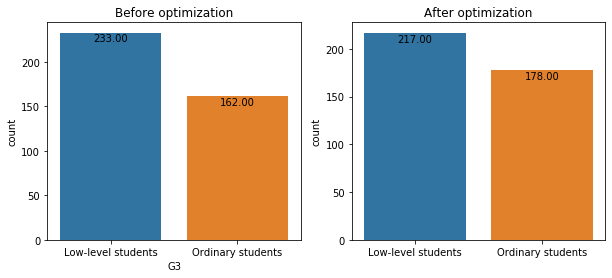

In [115]:
# result

fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.countplot((df.G3 > 11).replace({True:'Ordinary students',False:'Low-level students'}),ax=ax[0])
ax[0].set_title('Before optimization')
sns.countplot(['Ordinary students' if x == True else 'Low-level students' for x in (no_alco_df_preds > 11)],ax = ax[1])
ax[1].set_title('After optimization')
for ax_ in ax.flatten():
    show_values_on_bars(ax_)
    
print('Low-level students percentage before optimization: %.4f' % (sum(df.G3 < 11) / df.shape[0] * 100))
print('Low-level students percentage after optimization: %.4f' % (sum(no_alco_df_preds < 11) / df.shape[0] * 100))

#### lets check DPMO

In [125]:
corr_G1[corr_G1 < 0]

Fjob_at_home     -0.013385
Fjob_services    -0.016108
reason_home      -0.021359
famsup           -0.039157
school_MS        -0.045017
Walc             -0.051939
Fjob_other       -0.053483
Dalc             -0.054660
Pstatus_T        -0.058009
health           -0.061335
famsize_GT3      -0.081407
schoolsup        -0.082788
guardian_other   -0.087774
Mjob_other       -0.096477
reason_course    -0.098950
sex_F            -0.103456
address_R        -0.105756
Mjob_at_home     -0.115634
traveltime       -0.117142
romantic         -0.129970
goout            -0.132791
age              -0.161579
failures         -0.360415
Name: G3, dtype: float64

In [123]:
P = df.shape[0]
D = df[df['G3'] < 11 ].shape[0]

# all fetures with negative correlation without Dalc and Walc
O = corr_G1[corr_G1 < 0].shape[0] - 2

DPM = D / P * O
DPMO = D / P * O * 1000000
print(f'Students with underline scores = {D}(defects), all studens = {P}(products),  features = {O}(opportunity):\n',
      f'DPM = {DPM}',
      f'DPMO = {round(DPMO, 3)}',
      sep='\n')

Students with underline scores = 186(defects), all studens = 395(products),  features = 21(opportunity):

DPM = 9.888607594936708
DPMO = 9888607.595
